In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
with ZipFile('Data/2020_stat.zip', 'r') as zipObj:
  zipObj.extractall('Data')

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/MIE479/HPI')
!ls '/content/drive/MyDrive/MIE479/HPI'

 2020_HPI.csv  'Linear SVM Additional Variables.ipynb'


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [ ]:
# Try to find the HPI by reducing ZIP code until a match is found
def find_hpi(zip_code, year_quarter):

    while zip_code > 0:
        try:
            hpi_value = index_df.loc[zip_code, year_quarter]
            if not pd.isna(hpi_value):
                return hpi_value      # Valid HPI found
        except KeyError:
            pass       # ZIP code or Year_Quarter not found, continue reducing ZIP code
        zip_code -= 1
    return np.nan      # If no valid HPI is found, return NaN


In [ ]:
file_name = '/content/Data/2020_stat.csv'
table = pd.read_csv(file_name, low_memory=False).dropna()

table = table[[
    'ORIG_RATE', 'ORIG_AMOUNT', 'ORIG_TERM', 'OLTV', 'NUM_BO', 'DTI', 'CSCORE_B', # 'CSCORE_C',
    'FTHB_FLAG', 'PUR_Cash_out', 'PUR_Refinance', 'PUR_Purchase', 'NUM_UNIT',
    'OCC_Principal', 'OCC_Second', 'OCC_Investor', 'MI_PCT', 'DLQ_30_FLAG', 'DLQ_90_FLAG',
    'Ongoing', 'Current_DLQ', 'Prepaid_Matured', 'ORIG_DTE', 'ZIP']]

# Available delinquency flags: 30-day, 60-day, 90-day, and 120-day

# Definition of Bad Loans: once had a 90-day delinquency in performance history
# Definition of Good Loans: no delinquency and continuous payments up to current
table = table[ (table['DLQ_90_FLAG'] == 1) | ( (table['DLQ_90_FLAG'] == 0) & (table['Ongoing'] == 1) ) ]

In [ ]:
index_df = pd.read_csv('/content/Data/HPI_reformat.csv')
index_df = index_df.set_index('Three-Digit ZIP Code')

table['ORIG_DTE'] = pd.to_datetime(table['ORIG_DTE'])
table['YQ_ORIG'] = table['ORIG_DTE'].dt.to_period('Q').astype(str)
table['YQ_1y'] = (table['ORIG_DTE'] - pd.DateOffset(years=1)).dt.to_period('Q').astype(str)
table['YQ_2y'] = (table['ORIG_DTE'] - pd.DateOffset(years=2)).dt.to_period('Q').astype(str)
table['YQ_3y'] = (table['ORIG_DTE'] - pd.DateOffset(years=3)).dt.to_period('Q').astype(str)
table['YQ_4y'] = (table['ORIG_DTE'] - pd.DateOffset(years=4)).dt.to_period('Q').astype(str)
table['YQ_5y'] = (table['ORIG_DTE'] - pd.DateOffset(years=5)).dt.to_period('Q').astype(str)

for times in ['YQ_ORIG', 'YQ_1y', 'YQ_2y', 'YQ_3y', 'YQ_4y', 'YQ_5y']:
    table[f'HPI_{times}'] = table.apply(lambda row: find_hpi(row['ZIP'], row[times]), axis=1)
    print(f"HPI_{times} is completed.")

table = table.dropna(subset=['HPI_YQ_ORIG', 'HPI_YQ_1y', 'HPI_YQ_2y', 'HPI_YQ_3y', 'HPI_YQ_4y', 'HPI_YQ_5y'])

# HPI compared with previous year
table['HPI_ORIG_1y'] = table['HPI_YQ_ORIG'] / table['HPI_YQ_1y']
table['HPI_1y_2y'] = table['HPI_YQ_1y'] / table['HPI_YQ_2y']
table['HPI_2y_3y'] = table['HPI_YQ_2y'] / table['HPI_YQ_3y']
table['HPI_3y_4y'] = table['HPI_YQ_3y'] / table['HPI_YQ_4y']
table['HPI_4y_5y'] = table['HPI_YQ_4y'] / table['HPI_YQ_5y']

table = table.drop(columns=['YQ_ORIG', 'YQ_1y', 'YQ_2y', 'YQ_3y', 'YQ_4y', 'YQ_5y',
        'HPI_YQ_ORIG', 'HPI_YQ_1y', 'HPI_YQ_2y', 'HPI_YQ_3y', 'HPI_YQ_4y', 'HPI_YQ_5y'])

table.to_csv('/content/drive/MyDrive/MIE479/HPI/2020_HPI.csv', index=False)

HPI_YQ_ORIG is completed.
HPI_YQ_1y is completed.
HPI_YQ_2y is completed.
HPI_YQ_3y is completed.
HPI_YQ_4y is completed.
HPI_YQ_5y is completed.


In [ ]:
# If the HPI columns have already been added
file_name = '/content/drive/MyDrive/MIE479/HPI/2020_HPI.csv'
table = pd.read_csv(file_name, low_memory=False)

In [5]:
X = table.drop(columns=['DLQ_30_FLAG', 'DLQ_90_FLAG', 'Ongoing', 'Current_DLQ', 'Prepaid_Matured',
                        'ORIG_DTE', 'ZIP'])
y = table['DLQ_90_FLAG']

# CSCORE_B and CSCORE_C are highly correlated
num_col = ['ORIG_RATE', 'ORIG_AMOUNT', 'ORIG_TERM', 'OLTV', 'NUM_BO', 'DTI', 'CSCORE_B', # 'CSCORE_C',
           'NUM_UNIT', 'MI_PCT', 'HPI_ORIG_1y', 'HPI_1y_2y', 'HPI_2y_3y', 'HPI_3y_4y', 'HPI_4y_5y']
cat_col = ['FTHB_FLAG', 'PUR_Cash_out', 'PUR_Refinance', 'PUR_Purchase', 'OCC_Principal', 'OCC_Second', 'OCC_Investor']
scaler = StandardScaler()
X[num_col] = scaler.fit_transform(X[num_col])
X = pd.concat([X[num_col], X[cat_col]], axis=1)

X

,ORIG_RATE,ORIG_AMOUNT,ORIG_TERM,OLTV,NUM_BO,DTI,CSCORE_B,NUM_UNIT,MI_PCT,HPI_ORIG_1y,...,HPI_2y_3y,HPI_3y_4y,HPI_4y_5y,FTHB_FLAG,PUR_Cash_out,PUR_Refinance,PUR_Purchase,OCC_Principal,OCC_Second,OCC_Investor
0,5.967578,-0.041970,0.583235,0.558688,-0.961138,1.209533,-2.728868,-0.110778,-0.514104,-0.217707,...,-0.148806,-0.481220,-0.443363,0,1,0,0,1,0,0
1,2.077307,0.221725,0.583235,-0.005569,-0.961138,-0.404655,-2.285486,-0.110778,-0.514104,-0.276750,...,0.055054,0.708582,1.175393,0,1,0,0,1,0,0
2,1.311669,1.306641,0.583235,0.558688,0.975991,-0.101995,-0.709015,-0.110778,-0.514104,0.039765,...,-0.085590,-0.544514,-0.377376,0,0,1,0,1,0,0
3,1.580677,-1.013873,0.583235,1.405074,-0.961138,-0.909089,0.596500,-0.110778,2.219113,-0.852012,...,-0.914088,-0.426067,-0.843565,1,0,0,1,1,0,0
4,1.808299,-1.435785,0.583235,1.122945,0.975991,-2.422391,0.744294,-0.110778,1.763577,-0.100990,...,0.247431,-0.127553,-0.636572,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3260086,-2.557908,-0.689905,-1.827635,-2.939707,-0.961138,-0.909089,0.399441,-0.110778,-0.514104,1.237903,...,0.071656,2.252840,2.082932,1,0,0,1,1,0,0
3260087,-1.274947,0.372408,0.583235,-0.795529,-0.961138,-1.817070,0.547235,-0.110778,-0.514104,0.385526,...,-0.397731,0.564717,0.395276,0,0,1,0,1,0,0
3260088,-0.488616,-1.021407,0.583235,-1.359787,-0.961138,1.209533,0.941353,-0.110778,-0.514104,0.037345,...,-0.831051,-0.532998,-0.993180,0,0,1,0,1,0,0
3260089,0.546031,-1.157022,0.583235,0.558688,-0.961138,1.007759,-2.605706,-0.110778,-0.514104,0.901070,...,-0.377689,-0.413159,-0.470380,1,0,0,1,1,0,0


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=255)

svm_model = LinearSVC(random_state=255, max_iter=19999, class_weight='balanced')
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {round(accuracy, 4)}")
print(f"AUC-ROC: {round(roc_auc, 4)}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)

Accuracy: 0.7625
AUC-ROC: 0.7642
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.76      0.86    950069
           1       0.09      0.77      0.16     27959

    accuracy                           0.76    978028
   macro avg       0.54      0.76      0.51    978028
weighted avg       0.97      0.76      0.84    978028



In [7]:
print(round(y_test.sum() / len(y_test), 4))
print(round(y_pred.sum() / len(y_pred), 4))

0.0286
0.2527


In [8]:
import pickle

with open('/content/drive/MyDrive/MIE479/HPI/linear_svm_model_2020_HPI.pkl', 'wb') as file:
    pickle.dump(svm_model, file)

In [9]:
coefficients = svm_model.coef_  # Shape: (1, 21)
intercept = svm_model.intercept_  # Shape: (1,)

print("Coefficients (w):")
print(coefficients)

print("Intercept (b):")
print(intercept)

Coefficients (w):
[[ 0.28192396  0.10073025 -0.04561427  0.07142638 -0.1095971   0.14844334
  -0.21728936  0.00490754  0.06204564 -0.0324078   0.0259952   0.036541
  -0.03166656  0.02269676 -0.00077763 -0.09925347 -0.08157694 -0.08434344
   0.03914047 -0.07505774 -0.22925659]]
Intercept (b):
[-0.26517386]


In [ ]:
### Radial Basis Function Kernel

data = pd.concat([X, y], axis=1)
sampled = data.sample(n=500000, random_state=511)
X_new = sampled.iloc[:, :-1]
y_new = sampled.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, random_state=511)

non_linear_svm = SVC(kernel='rbf', class_weight='balanced', C=1.0, gamma='scale', random_state=511)
non_linear_svm.fit(X_train, y_train)

y_pred = non_linear_svm.predict(X_test)

y_pred_prob = non_linear_svm.decision_function(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC-ROC: {round(roc_auc, 4)}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

AUC-ROC: 0.8231
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.76      0.86    145636
           1       0.09      0.75      0.16      4364

    accuracy                           0.76    150000
   macro avg       0.54      0.76      0.51    150000
weighted avg       0.96      0.76      0.84    150000



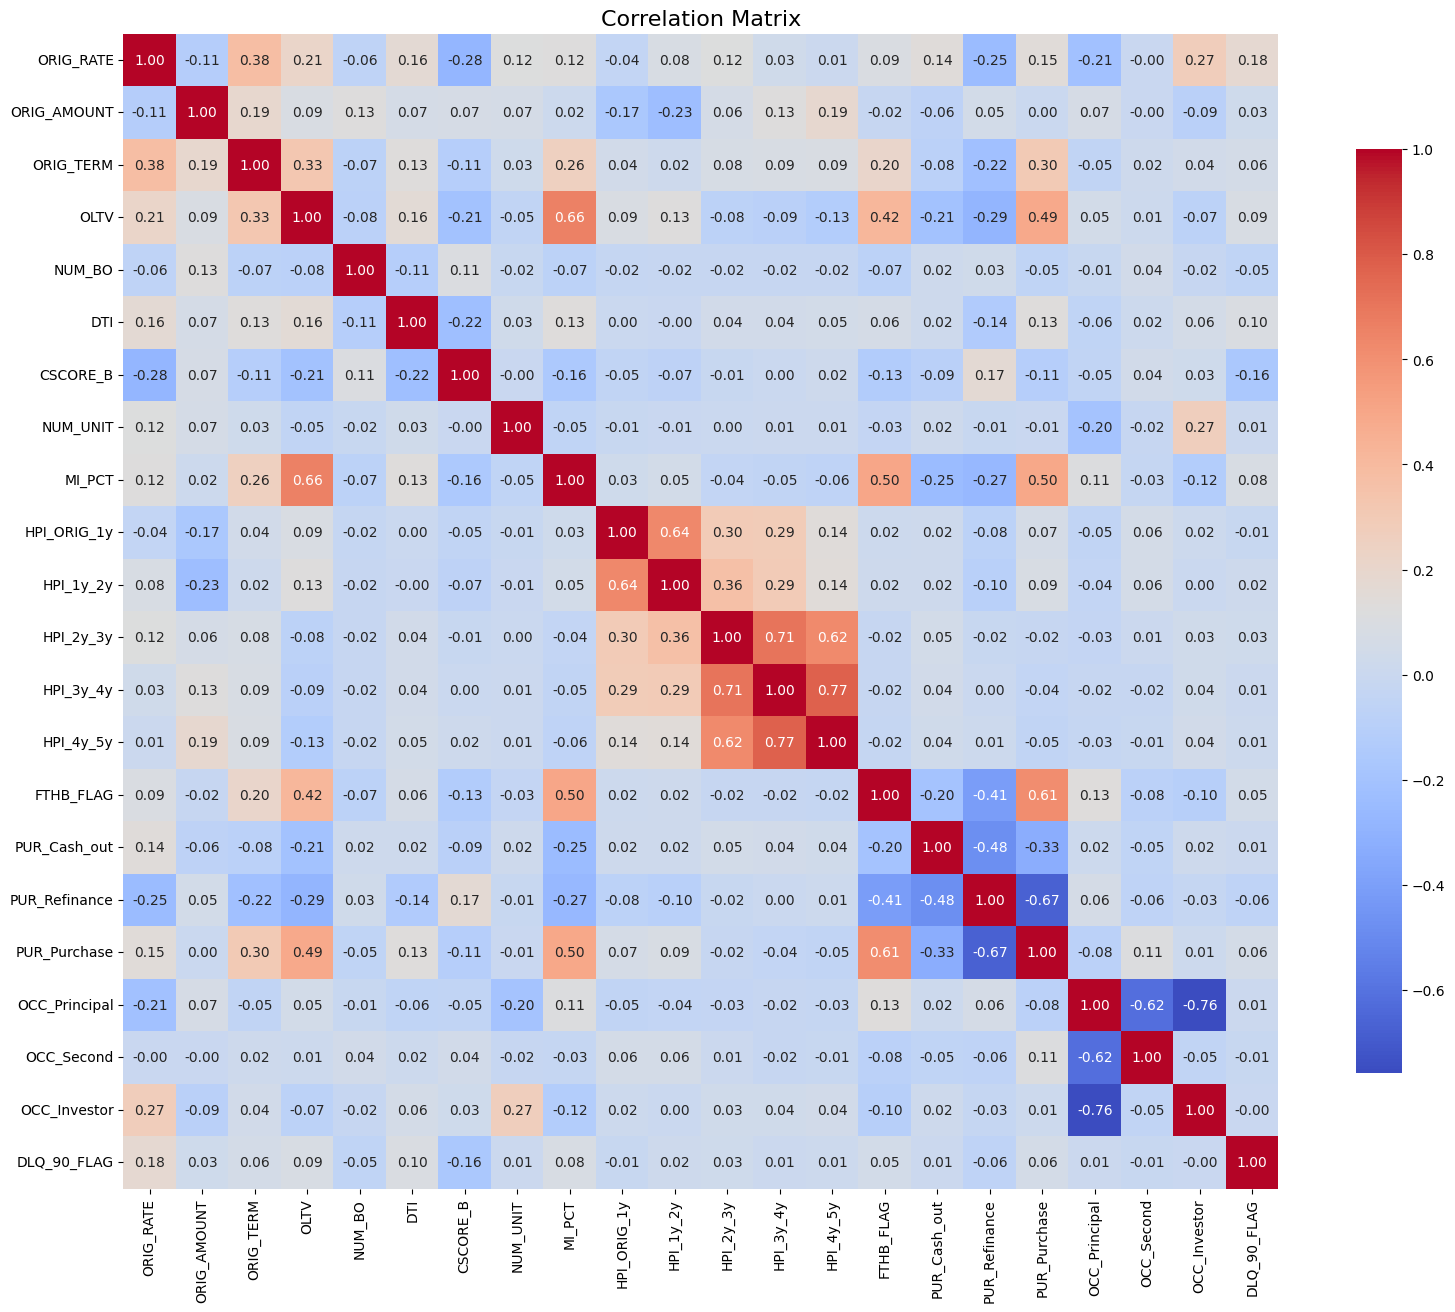

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute matrix
correlation_matrix = data.corr()
# Create a heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix,
             annot=True,
             fmt=".2f",
             cmap='coolwarm',
             square=True,
             cbar_kws={"shrink": .8}
            )
plt.title('Correlation Matrix', fontsize=16)
plt.show()